## Задача ноутбука: классификация облаков на спутниковой фотографии

### Исходя из датасета, облкак могут относиться к одному из четырех классов. При этом, на одной фотографии могут присутствовать облака разных классов

В данном ноутбуке не реализовано выделение облаков на фотографии, как этого требует задание на Kaggle.

In [1]:
%pip install pytorch-ignite

  Obtaining dependency information for pytorch-ignite from https://files.pythonhosted.org/packages/6b/43/db683e79af5ba9dc79e97295d6c7b199856712be680ad1e6751d26413b3f/pytorch_ignite-0.5.1-py3-none-any.whl.metadata
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 312.7/312.7 kB 4.9 MB/s eta 0:00:00a 0:00:01

[notice] A new release of pip is available: 23.2.1 -> 24.2
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [861]:
import os

import numpy as np
import pandas as pd
import torch
from PIL import Image
from torch import optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data import DataLoader, Dataset
from torch.utils.data import random_split
from torchvision import transforms
from torchvision import utils

from sklearn.preprocessing import OneHotEncoder

In [795]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
%matplotlib inline

Исходя из датасета, данные были подвергнуты следующей обработке:

- Строки были сгруппированы по имени (номеру) фото
- Для каждого фото были определены присутствующие классы облаков
- Классы были закодированы OneHotEncoder
- Данные подготовлены для MultiLabel Classification.

Так же можно классифицировать конкретный вид облаков, но мне показалось, что это недостаточная реализация.

In [809]:
torch.manual_seed(42)  # fix random seed


class pytorch_data(Dataset):
    def __init__(self, data_dir, transform, data_type="train"):
        # Get Image File Names
        cdm_data = os.path.join(data_dir, f'{data_type}_images')  # directory of files

        file_names = os.listdir(cdm_data)  # get list of images in that directory  
        idx_choose = np.random.choice(np.arange(len(file_names)),
                                      4000,
                                      replace=False).tolist()
        file_names_sample = [file_names[x] for x in idx_choose]
        self.full_filenames = [os.path.join(cdm_data, f) for f in file_names_sample]  # get the full path to images

        # Get Labels
        labels_data = os.path.join(data_dir, "train.csv")
        labels_df = pd.read_csv(labels_data)
        labels_df['image'] = labels_df['Image_Label'].map(lambda x: x.split('_')[0])
        labels_df['label'] = labels_df['Image_Label'].map(lambda x: x.split('_')[1])
        labels_df['id'] = labels_df['image'].map(lambda x: x.split('.')[0])
        enc = OneHotEncoder(handle_unknown='ignore')
        encoded_labels = enc.fit_transform(labels_df[['label']])
        encoded_labels = pd.DataFrame.sparse.from_spmatrix(encoded_labels, columns=enc.categories_, index=labels_df.index)
        self.targets = [x[0] for x in encoded_labels.columns]
        labels_df[self.targets] = encoded_labels

        labels_df = labels_df.dropna().drop(columns=['label', 'EncodedPixels', 'Image_Label']).groupby(['id', 'image']).agg(sum)
        self.df = labels_df

        if 'id' in labels_df.columns:
            labels_df.set_index("id", inplace=True)  # set data frame index to id
        self.labels = labels_df[self.targets]  # obtained labels from df
        self.transform = transform

    def __len__(self):
        return len(self.full_filenames)  # size of dataset

    def __getitem__(self, idx):
        # open image, apply transforms and return with label
        image = Image.open(self.full_filenames[idx])  # Open Image with PIL
        image = self.transform(image)  # Apply Specific Transformation to Image
        return image, torch.Tensor(self.labels.iloc[idx].values.tolist())

Данные переводятся в кастомный класс датасета, разделяются на train-test и упаковываются в DataLoader

In [810]:
# transform to normalize the data

train_size = 0.7

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((350, 350)),
])
img_dataset = pytorch_data('./data/understanding_cloud_organization/', transform)

len_img = len(img_dataset)
len_train = int(train_size * len_img)
len_val = len_img - len_train

train_ts, val_ts = random_split(img_dataset, [len_train, len_val])  # random split 80/20

print("train dataset size:", len(train_ts))
print("validation dataset size:", len(val_ts))

train_loader = DataLoader(img_dataset, batch_size=1024, shuffle=True)
val_loader = DataLoader(val_ts, batch_size=1024, shuffle=True)

/var/folders/h0/z7lpdx1d2l5gfkb9nt4d_rjc0000gn/T/ipykernel_24734/2876919855.py:28: FutureWarning:

The provided callable <built-in function sum> is currently using DataFrameGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.



train dataset size: 3200
validation dataset size: 800


In [811]:
df = img_dataset.df[img_dataset.targets]
df.map(lambda x: int(x)).head()

,,Fish,Flower,Gravel,Sugar
id,image,,,,
0011165,0011165.jpg,1,1,0,0
002be4f,002be4f.jpg,1,1,0,1
0031ae9,0031ae9.jpg,1,1,0,1
0035239,0035239.jpg,0,1,1,0
003994e,003994e.jpg,1,0,1,1


In [812]:
import plotly.express as px


def plot_img(x, y, title=None):
    npimg = x.numpy() # convert tensor to numpy array
    npimg_tr=np.transpose(npimg, (1,2,0)) # Convert to H*W*C shape
    fig = px.imshow(npimg_tr)
    fig.update_layout(template='plotly_white')
    fig.update_layout(title=title,height=300,margin={'l':10,'r':20,'b':10})
    fig.show()

In [813]:
grid_size = 5
rnd_inds = np.random.randint(0, len(train_ts), grid_size)
print("image indices:", rnd_inds)

x_grid_train = [train_ts[i][0] for i in rnd_inds]
y_grid_train = [train_ts[i][1] for i in rnd_inds]

x_grid_train = utils.make_grid(x_grid_train, nrow=10, padding=2)
print(x_grid_train.shape)
print(y_grid_train)

plot_img(x_grid_train, y_grid_train, 'Training Subset Examples')

image indices: [2718 1874 1488 2498 2856]
torch.Size([3, 354, 1762])
[tensor([1., 0., 1., 1.]), tensor([0., 1., 1., 1.]), tensor([1., 1., 0., 1.]), tensor([0., 1., 0., 1.]), tensor([1., 0., 1., 1.])]


Далее идет класс модели. Подбором параметров в силу отсутствия времени я не занимался.

Модель принимает на вход фото 350х350, на выходе выдает тензор размера 4 с вероятностью отнесения к каждому классу.

In [843]:
def findConv2dOutShape(hin, win, conv, pool=2):
    # get conv arguments
    kernel_size = conv.kernel_size
    stride = conv.stride
    padding = conv.padding
    dilation = conv.dilation

    hout = np.floor((hin + 2 * padding[0] - dilation[0] * (kernel_size[0] - 1) - 1) / stride[0] + 1)
    wout = np.floor((win + 2 * padding[1] - dilation[1] * (kernel_size[1] - 1) - 1) / stride[1] + 1)

    if pool:
        hout /= pool
        wout /= pool
    return int(hout), int(wout)


import torch.nn as nn
import torch.nn.functional as F


# Neural Network
class Network(nn.Module):

    # Network Initialisation
    def __init__(self, params):
        super(Network, self).__init__()

        Cin, Hin, Win = params["shape_in"]
        init_f = params["initial_filters"]
        num_fc1 = params["num_fc1"]
        num_classes = params["num_classes"]
        self.dropout_rate = params["dropout_rate"]

        # Convolution Layers
        self.conv1 = nn.Conv2d(Cin, init_f, kernel_size=3)
        h, w = findConv2dOutShape(Hin, Win, self.conv1)
        self.conv2 = nn.Conv2d(init_f, 2 * init_f, kernel_size=3)
        h, w = findConv2dOutShape(h, w, self.conv2)
        self.conv3 = nn.Conv2d(2 * init_f, 4 * init_f, kernel_size=3)
        h, w = findConv2dOutShape(h, w, self.conv3)
        self.conv4 = nn.Conv2d(4 * init_f, 8 * init_f, kernel_size=3)
        h, w = findConv2dOutShape(h, w, self.conv4)

        # compute the flatten size
        self.num_flatten = h * w * 8 * init_f
        self.fc1 = nn.Linear(self.num_flatten, num_fc1)
        self.fc2 = nn.Linear(num_fc1, num_classes)

    def forward(self, X):
        # Convolution & Pool Layers
        X = F.relu(self.conv1(X));
        X = F.max_pool2d(X, 2, 2)
        X = F.relu(self.conv2(X))
        X = F.max_pool2d(X, 2, 2)
        X = F.relu(self.conv3(X))
        X = F.max_pool2d(X, 2, 2)
        X = F.relu(self.conv4(X))
        X = F.max_pool2d(X, 2, 2)

        X = X.view(-1, self.num_flatten)

        X = F.relu(self.fc1(X))
        X = F.dropout(X, self.dropout_rate)
        X = self.fc2(X)
        return F.sigmoid(X)

В задании требуется проверять модель DiceKoef, но я не нашел его реализацию для multilabel classification, поэтому была использована метрика бинарной кросс-энтропии. 

In [853]:
params_model = {
    "shape_in": (3, 350, 350),
    "initial_filters": 8,
    "num_fc1": 100,
    "dropout_rate": 0.25,
    "num_classes": 4
}

# Create instantiation of Network class
cnn_model = Network(params_model)

# define computation hardware approach (GPU/CPU)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
cnn_model = cnn_model.to(device)
optimizer = optim.Adam(cnn_model.parameters(), lr=0.001)
criterion = nn.BCELoss()

In [854]:
from ignite.engine import Events
from ignite.handlers import ModelCheckpoint, EarlyStopping
from ignite.metrics import Accuracy, Loss, ConfusionMatrix, MultiLabelConfusionMatrix
from ignite.engine import create_supervised_trainer, create_supervised_evaluator

В качестве дополнительных использовались accuracy (Dice не дает возможности добавить его сюда, выдавал ошибку) и ConfusionMatrix.

In [855]:
# defining the number of epochs
epochs = 3
# creating trainer,evaluator
trainer = create_supervised_trainer(cnn_model, optimizer, criterion, device=device)


def activated_output_transform(output):
    y_pred, y = output
    y_pred = (y_pred > 0.5)
    return y_pred.int(), y.int()


metrics = {
    'accuracy':Accuracy(activated_output_transform),
    'bce': Loss(criterion),
    'cm': MultiLabelConfusionMatrix(num_classes=4, output_transform=activated_output_transform)
}
train_evaluator = create_supervised_evaluator(cnn_model, metrics=metrics, device=device)
val_evaluator = create_supervised_evaluator(cnn_model, metrics=metrics, device=device)
training_history = {'accuracy': [], 'loss': []}
validation_history = {'accuracy': [], 'loss': []}
last_epoch = []

Функция EarlyStopping для останова по метрике

In [856]:
def score_function(engine):
    val_loss = engine.state.metrics['bce']
    return -val_loss

handler = EarlyStopping(patience=10, score_function=score_function, trainer=trainer)
val_evaluator.add_event_handler(Events.COMPLETED, handler)

Логирование метрик

In [857]:
@trainer.on(Events.EPOCH_COMPLETED)
def log_training_results(trainer):
    train_evaluator.run(train_loader)
    metrics = train_evaluator.state.metrics
    accuracy = metrics['accuracy']*100
    loss = metrics['bce']
    last_epoch.append(0)
    training_history['accuracy'].append(accuracy)
    training_history['loss'].append(loss)
    print("Training Results - Epoch: {}  Avg accuracy: {:.2f} Avg loss: {:.2f}"
          .format(trainer.state.epoch, accuracy, loss))

def log_validation_results(trainer):
    val_evaluator.run(val_loader)
    metrics = val_evaluator.state.metrics
    accuracy = metrics['accuracy']*100
    loss = metrics['bce']
    validation_history['accuracy'].append(accuracy)
    validation_history['loss'].append(loss)
    print("Validation Results - Epoch: {}  Avg accuracy: {:.2f} Avg loss: {:.2f}"
          .format(trainer.state.epoch, accuracy, loss))

trainer.add_event_handler(Events.EPOCH_COMPLETED, log_validation_results)

In [858]:
from sklearn.metrics import ConfusionMatrixDisplay


@trainer.on(Events.COMPLETED)
def log_confusion_matrix(trainer):
    val_evaluator.run(val_loader)
    metrics = val_evaluator.state.metrics
    cm = metrics['cm']
    cm = cm.numpy()
    cm = cm.astype(int)
    classes = img_dataset.targets
    f, axes = plt.subplots(2, 2, figsize=(10, 10))
    axes = axes.ravel()
    for i, _class in enumerate(classes):
        disp = ConfusionMatrixDisplay(cm[i])
        disp.plot(ax=axes[i], values_format='.4g')
        disp.ax_.set_title(_class)
        disp.im_.colorbar.remove()
        
    plt.subplots_adjust(wspace=0.10, hspace=0.1)
    f.colorbar(disp.im_, ax=axes)
    plt.show()

In [859]:
checkpointer = ModelCheckpoint(
    './saved_models', 'fashionMNIST', n_saved=2, create_dir=True, require_empty=False
)
trainer.add_event_handler(Events.EPOCH_COMPLETED, checkpointer, {'fashionMNIST': cnn_model})

Далее запускается обучение. Как видно, минимальный прогресс есть, но в идеале нужно тюнить параметры модели и увеличивать количество эпох. На малом количестве результаты ожидаемо плохие. 

ЗЫ: цвета CM вырвиглазные, но тут как получилось)

Training Results - Epoch: 1  Avg accuracy: 56.61 Avg loss: 0.68
Validation Results - Epoch: 1  Avg accuracy: 59.31 Avg loss: 0.67
Training Results - Epoch: 2  Avg accuracy: 56.93 Avg loss: 0.67
Validation Results - Epoch: 2  Avg accuracy: 58.28 Avg loss: 0.67
Training Results - Epoch: 3  Avg accuracy: 56.77 Avg loss: 0.68
Validation Results - Epoch: 3  Avg accuracy: 58.03 Avg loss: 0.67


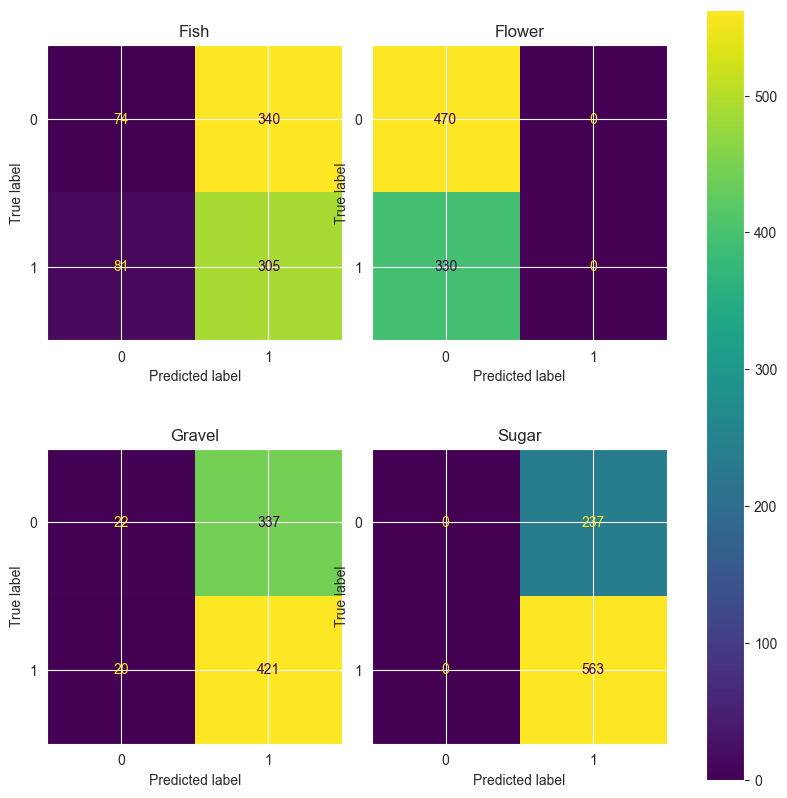

State:
	iteration: 12
	epoch: 3
	epoch_length: 4
	max_epochs: 3
	output: 0.6820209622383118
	batch: <class 'list'>
	metrics: <class 'dict'>
	dataloader: <class 'torch.utils.data.dataloader.DataLoader'>
	seed: <class 'NoneType'>
	times: <class 'dict'>

In [860]:
trainer.run(train_loader, max_epochs=epochs)

Далее идут графики `Accuracy` и `Loss` процесса обучения

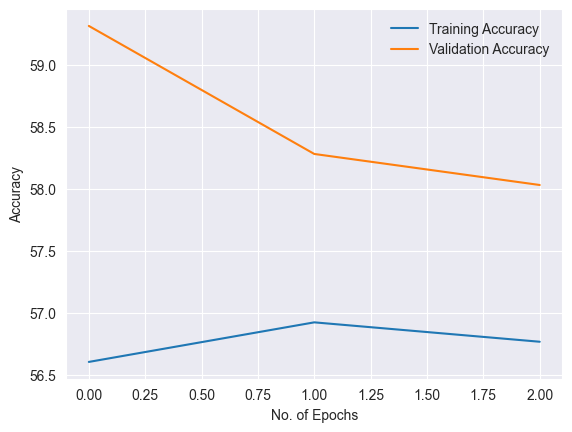

In [862]:
plt.plot(training_history['accuracy'], label="Training Accuracy")
plt.plot(validation_history['accuracy'], label="Validation Accuracy")
plt.xlabel('No. of Epochs')
plt.ylabel('Accuracy')
plt.legend(frameon=False)
plt.show()

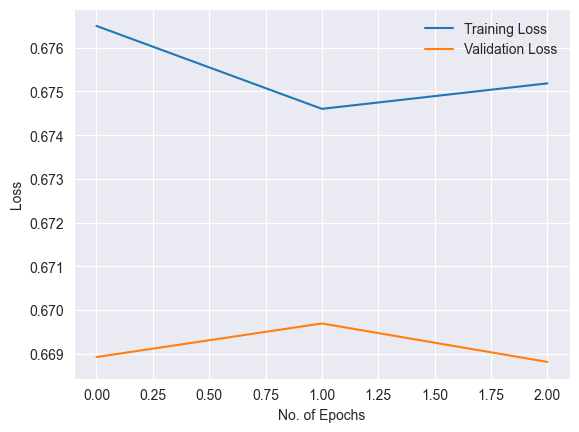

In [863]:
plt.show()
plt.plot(training_history['loss'], label="Training Loss")
plt.plot(validation_history['loss'], label="Validation Loss")
plt.xlabel('No. of Epochs')
plt.ylabel('Loss')
plt.legend(frameon=False)
plt.show()